In [1]:
from Data_Preprocessing import exp_var, hate_crime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.ensemble import RandomForestRegressor

C:\Users\aspen\Documents\LAUNCH-CODE\Final_Project\Data_Preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df['INCIDENT_MONTH'] = pd.to_datetime(ts_df['INCIDENT_DATE']).dt.to_period('M')
C:\Users\aspen\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\aspen\Documents\LAUNCH-CODE\Final_Project\Data_Preprocessing.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [2]:
exp_var

['hate_crime',
 'hate_crime_combined',
 'hc_by_year',
 'region_grouped',
 'race_grouped',
 'indexed_df']

### Supervised Learning with Timeseries

https://www.bi4all.pt/en/news/en-blog/supervised-machine-learning-in-time-series-forecasting/

https://machinelearningmastery.com/how-to-develop-an-autoregression-forecast-model-for-household-electricity-consumption/

https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

In [3]:
#create lag features t, t-1, t-2, etc
#can compute more advanced features like rolling mean pd rolling() 
#or expanding windows pd expanding()
#use ridge regression to select most impactful lag features

#walk forward validation with sklearn TimeSeriesSplit()

#evaluation with MAE, MSE, RMSE

In [4]:
hate_crime

,DATA_YEAR,STATE_ABBR,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,TOTAL_INCIDENTS
0,1991,AR,South,5,1991-08-31,1,White,1,Intimidation,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,1
1,1991,AR,South,6,1991-09-19,1,Black or African American,1,Simple Assault,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,1
2,1991,AR,South,3,1991-07-04,1,Black or African American,1,Aggravated Assault,Residence/Home,Anti-Black or African American,Individual,1
3,1991,AR,South,3,1991-12-24,1,Black or African American,2,Aggravated Assault;Destruction/Damage/Vandalis...,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,1
4,1991,AR,South,3,1991-12-23,1,Black or African American,1,Aggravated Assault,Service/Gas Station,Anti-White,Individual,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219572,2020,WY,West,5,2020-11-29,6,White,2,Intimidation,Park/Playground,Anti-Lesbian (Female),Individual,1
219573,2020,WY,West,5,2020-07-14,0,Unknown,1,Destruction/Damage/Vandalism of Property,Park/Playground,Anti-White,Government,1
219574,2020,WY,West,5,2020-10-16,1,Black or African American,1,Aggravated Assault,Residence/Home,Anti-White,Individual,1
219575,2020,WY,West,5,2020-01-30,1,White,1,Simple Assault,Residence/Home,Anti-Female,Individual,1


In [5]:
#group by bias type -- ADD THIS TO VSCODE LATER

bias_grouped = hate_crime.groupby(['DATA_YEAR','BIAS_DESC'])['TOTAL_INCIDENTS'].sum().reset_index()
bias_grouped.set_index('DATA_YEAR', inplace=True)
bias_grouped

,BIAS_DESC,TOTAL_INCIDENTS
DATA_YEAR,,
1991,Anti-Arab,73
1991,Anti-Asian,269
1991,Anti-Atheism/Agnosticism,4
1991,Anti-Bisexual,1
1991,Anti-Black or African American,1629
...,...,...
2020,Anti-Physical Disability,72
2020,Anti-Protestant,40
2020,Anti-Sikh,172


In [6]:
bias_grouped[bias_grouped['TOTAL_INCIDENTS'] > 1000]

,BIAS_DESC,TOTAL_INCIDENTS
DATA_YEAR,,
1991,Anti-Black or African American,1629
1992,Anti-Black or African American,2313
1992,Anti-Jewish,1020
1992,Anti-White,1349
1993,Anti-Black or African American,2827
1993,Anti-Jewish,1141
1993,Anti-White,1476
1994,Anti-Black or African American,2179
1994,Anti-White,1014


In [7]:
muslim_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Islamic (Muslim)"]
black_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Black or African American"]
asian_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Asian"]
queer_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Gay (Male)"] + bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Lesbian (Female)"]


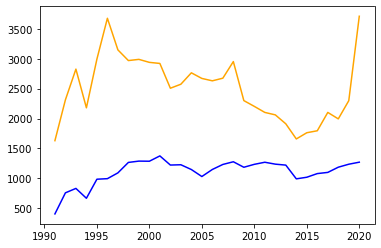

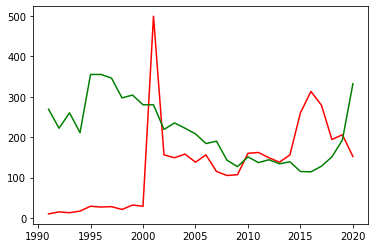

In [8]:
# muslim_bias.plot()
# black_bias.plot()
# asian_bias.plot()
# queer_bias.plot()


plt.plot(black_bias['TOTAL_INCIDENTS'], color='orange')
plt.plot(queer_bias['TOTAL_INCIDENTS'], color='blue')

plt.show()

plt.plot(muslim_bias['TOTAL_INCIDENTS'], color='red')


plt.plot(asian_bias['TOTAL_INCIDENTS'], color='green')

plt.show()

#### Timeseries with monthly number of incidents per region

In [9]:
region_ts = hate_crime[['INCIDENT_DATE', 'REGION_NAME', 'TOTAL_INCIDENTS']]
region_ts

,INCIDENT_DATE,REGION_NAME,TOTAL_INCIDENTS
0,1991-08-31,South,1
1,1991-09-19,South,1
2,1991-07-04,South,1
3,1991-12-24,South,1
4,1991-12-23,South,1
...,...,...,...
219572,2020-11-29,West,1
219573,2020-07-14,West,1
219574,2020-10-16,West,1
219575,2020-01-30,West,1


In [10]:
region_ts['INCIDENT_MONTH'] = pd.to_datetime(region_ts['INCIDENT_DATE']).dt.to_period('M')
region_ts['INCIDENT_MONTH'] = region_ts['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))

region_ts.drop('INCIDENT_DATE', axis=1, inplace=True)
region_ts

C:\Users\aspen\AppData\Local\Temp/ipykernel_13780/996105495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_ts['INCIDENT_MONTH'] = pd.to_datetime(region_ts['INCIDENT_DATE']).dt.to_period('M')
C:\Users\aspen\AppData\Local\Temp/ipykernel_13780/996105495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_ts['INCIDENT_MONTH'] = region_ts['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))
C:\Users\aspen\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A 

,REGION_NAME,TOTAL_INCIDENTS,INCIDENT_MONTH
0,South,1,1991-08-31
1,South,1,1991-09-30
2,South,1,1991-07-31
3,South,1,1991-12-31
4,South,1,1991-12-31
...,...,...,...
219572,West,1,2020-11-30
219573,West,1,2020-07-31
219574,West,1,2020-10-31
219575,West,1,2020-01-31


In [11]:
#groupby and set index to date
region_ts = region_ts.groupby(['INCIDENT_MONTH', 'REGION_NAME'])['TOTAL_INCIDENTS'].sum().reset_index()
#region_ts = region_ts.set_index('INCIDENT_MONTH')
region_ts

,INCIDENT_MONTH,REGION_NAME,TOTAL_INCIDENTS
0,1991-01-31,Midwest,37
1,1991-01-31,Northeast,171
2,1991-01-31,South,65
3,1991-01-31,West,29
4,1991-02-28,Midwest,51
...,...,...,...
1478,2020-12-31,Midwest,139
1479,2020-12-31,Northeast,144
1480,2020-12-31,Other,7
1481,2020-12-31,South,176


In [12]:
#categorical encoding
region_ts['REGION_NAME'] = region_ts['REGION_NAME'].astype('category')
region_ts['REGION_NAME_ENC'] = region_ts['REGION_NAME'].cat.codes

region_df = region_ts[['REGION_NAME']]
region_ts.drop('REGION_NAME', axis=1, inplace=True)
region_ts

,INCIDENT_MONTH,TOTAL_INCIDENTS,REGION_NAME_ENC
0,1991-01-31,37,0
1,1991-01-31,171,1
2,1991-01-31,65,3
3,1991-01-31,29,5
4,1991-02-28,51,0
...,...,...,...
1478,2020-12-31,139,0
1479,2020-12-31,144,1
1480,2020-12-31,7,2
1481,2020-12-31,176,3


#### Timeseries with Monthly number of incidents per bias

In [13]:
bias_ts = hate_crime[['INCIDENT_DATE', 'BIAS_DESC', 'TOTAL_INCIDENTS']]
bias_ts

,INCIDENT_DATE,BIAS_DESC,TOTAL_INCIDENTS
0,1991-08-31,Anti-Black or African American,1
1,1991-09-19,Anti-White,1
2,1991-07-04,Anti-Black or African American,1
3,1991-12-24,Anti-White,1
4,1991-12-23,Anti-White,1
...,...,...,...
219572,2020-11-29,Anti-Lesbian (Female),1
219573,2020-07-14,Anti-White,1
219574,2020-10-16,Anti-White,1
219575,2020-01-30,Anti-Female,1


In [14]:
bias_ts['INCIDENT_MONTH'] = pd.to_datetime(bias_ts['INCIDENT_DATE']).dt.to_period('M')
bias_ts['INCIDENT_MONTH'] = bias_ts['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))

bias_ts.drop('INCIDENT_DATE', axis=1, inplace=True)
bias_ts

C:\Users\aspen\AppData\Local\Temp/ipykernel_13780/1289471746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bias_ts['INCIDENT_MONTH'] = pd.to_datetime(bias_ts['INCIDENT_DATE']).dt.to_period('M')
C:\Users\aspen\AppData\Local\Temp/ipykernel_13780/1289471746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bias_ts['INCIDENT_MONTH'] = bias_ts['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))
C:\Users\aspen\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value 

,BIAS_DESC,TOTAL_INCIDENTS,INCIDENT_MONTH
0,Anti-Black or African American,1,1991-08-31
1,Anti-White,1,1991-09-30
2,Anti-Black or African American,1,1991-07-31
3,Anti-White,1,1991-12-31
4,Anti-White,1,1991-12-31
...,...,...,...
219572,Anti-Lesbian (Female),1,2020-11-30
219573,Anti-White,1,2020-07-31
219574,Anti-White,1,2020-10-31
219575,Anti-Female,1,2020-01-31


In [15]:
#groupby and set index to date
bias_ts = bias_ts.groupby(['INCIDENT_MONTH', 'BIAS_DESC'])['TOTAL_INCIDENTS'].sum().reset_index()
#bias_ts = bias_ts.set_index('INCIDENT_MONTH')
bias_ts

,INCIDENT_MONTH,BIAS_DESC,TOTAL_INCIDENTS
0,1991-01-31,Anti-Arab,25
1,1991-01-31,Anti-Asian,9
2,1991-01-31,Anti-Atheism/Agnosticism,1
3,1991-01-31,Anti-Black or African American,90
4,1991-01-31,Anti-Gay (Male),7
...,...,...,...
7359,2020-12-31,Anti-Physical Disability,7
7360,2020-12-31,Anti-Protestant,6
7361,2020-12-31,Anti-Sikh,14
7362,2020-12-31,Anti-Transgender,10


In [16]:
#categorical encoding
bias_ts['BIAS_DESC'] = bias_ts['BIAS_DESC'].astype('category')
bias_ts['BIAS_DESC_ENC'] = bias_ts['BIAS_DESC'].cat.codes

bias_df = bias_ts[['BIAS_DESC']]
bias_ts.drop('BIAS_DESC', axis=1, inplace=True)
bias_ts

,INCIDENT_MONTH,TOTAL_INCIDENTS,BIAS_DESC_ENC
0,1991-01-31,25,0
1,1991-01-31,9,1
2,1991-01-31,1,2
3,1991-01-31,90,4
4,1991-01-31,7,9
...,...,...,...
7359,2020-12-31,7,28
7360,2020-12-31,6,29
7361,2020-12-31,14,30
7362,2020-12-31,10,31


#### Timeseries with Region and Bias

In [17]:
region_bias_ts = hate_crime[['INCIDENT_DATE', 'REGION_NAME', 'BIAS_DESC', 'TOTAL_INCIDENTS']]
region_bias_ts

,INCIDENT_DATE,REGION_NAME,BIAS_DESC,TOTAL_INCIDENTS
0,1991-08-31,South,Anti-Black or African American,1
1,1991-09-19,South,Anti-White,1
2,1991-07-04,South,Anti-Black or African American,1
3,1991-12-24,South,Anti-White,1
4,1991-12-23,South,Anti-White,1
...,...,...,...,...
219572,2020-11-29,West,Anti-Lesbian (Female),1
219573,2020-07-14,West,Anti-White,1
219574,2020-10-16,West,Anti-White,1
219575,2020-01-30,West,Anti-Female,1


In [18]:
region_bias_ts['INCIDENT_MONTH'] = pd.to_datetime(region_bias_ts['INCIDENT_DATE']).dt.to_period('M')
region_bias_ts['INCIDENT_MONTH'] = region_bias_ts['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))

region_bias_ts.drop('INCIDENT_DATE', axis=1, inplace=True)
region_bias_ts

C:\Users\aspen\AppData\Local\Temp/ipykernel_13780/1771733128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_bias_ts['INCIDENT_MONTH'] = pd.to_datetime(region_bias_ts['INCIDENT_DATE']).dt.to_period('M')
C:\Users\aspen\AppData\Local\Temp/ipykernel_13780/1771733128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_bias_ts['INCIDENT_MONTH'] = region_bias_ts['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))
C:\Users\aspen\anaconda3\lib\site-packages\pandas\core\frame.py:4906: Setti

,REGION_NAME,BIAS_DESC,TOTAL_INCIDENTS,INCIDENT_MONTH
0,South,Anti-Black or African American,1,1991-08-31
1,South,Anti-White,1,1991-09-30
2,South,Anti-Black or African American,1,1991-07-31
3,South,Anti-White,1,1991-12-31
4,South,Anti-White,1,1991-12-31
...,...,...,...,...
219572,West,Anti-Lesbian (Female),1,2020-11-30
219573,West,Anti-White,1,2020-07-31
219574,West,Anti-White,1,2020-10-31
219575,West,Anti-Female,1,2020-01-31


In [19]:
region_bias_ts = region_bias_ts.groupby(['INCIDENT_MONTH', 'REGION_NAME','BIAS_DESC'])['TOTAL_INCIDENTS'].sum().reset_index()
#region_bias_ts = region_bias_ts.set_index('INCIDENT_MONTH')
region_bias_ts

,INCIDENT_MONTH,REGION_NAME,BIAS_DESC,TOTAL_INCIDENTS
0,1991-01-31,Midwest,Anti-Arab,7
1,1991-01-31,Midwest,Anti-Asian,1
2,1991-01-31,Midwest,Anti-Black or African American,10
3,1991-01-31,Midwest,Anti-Jewish,3
4,1991-01-31,Midwest,Anti-Native American,1
...,...,...,...,...
22156,2020-12-31,West,Anti-Physical Disability,1
22157,2020-12-31,West,Anti-Protestant,1
22158,2020-12-31,West,Anti-Sikh,1
22159,2020-12-31,West,Anti-Transgender,5


In [20]:
#categorical encoding
region_bias_ts['BIAS_DESC'] = region_bias_ts['BIAS_DESC'].astype('category')
region_bias_ts['BIAS_DESC_ENC'] = region_bias_ts['BIAS_DESC'].cat.codes

region_bias_ts['REGION_NAME'] = region_bias_ts['REGION_NAME'].astype('category')
region_bias_ts['REGION_NAME_ENC'] = region_bias_ts['REGION_NAME'].cat.codes

region_bias_df = region_bias_ts[['REGION_NAME', 'BIAS_DESC']]
region_bias_ts.drop(['REGION_NAME','BIAS_DESC'], axis=1, inplace=True)
region_bias_ts

,INCIDENT_MONTH,TOTAL_INCIDENTS,BIAS_DESC_ENC,REGION_NAME_ENC
0,1991-01-31,7,0,0
1,1991-01-31,1,1,0
2,1991-01-31,10,4,0
3,1991-01-31,3,16,0
4,1991-01-31,1,23,0
...,...,...,...,...
22156,2020-12-31,1,28,5
22157,2020-12-31,1,29,5
22158,2020-12-31,1,30,5
22159,2020-12-31,5,31,5


#### Engineering Lags Features

In [21]:
## create lag features with shift()

region_ts['MONTH-1_INCIDENTS'] = region_ts.groupby(['REGION_NAME_ENC'])['TOTAL_INCIDENTS'].shift()
region_ts['MONTH-1_DIFF'] = region_ts.groupby(['REGION_NAME_ENC'])['MONTH-1_INCIDENTS'].diff()
region_ts.dropna(inplace=True)
region_ts.reset_index(inplace=True)
region_ts

,index,INCIDENT_MONTH,TOTAL_INCIDENTS,REGION_NAME_ENC,MONTH-1_INCIDENTS,MONTH-1_DIFF
0,8,1991-03-31,40,0,51.0,14.0
1,9,1991-03-31,153,1,148.0,-23.0
2,10,1991-03-31,56,3,51.0,-14.0
3,11,1991-03-31,38,5,37.0,8.0
4,12,1991-04-30,51,0,40.0,-11.0
...,...,...,...,...,...,...
1466,1478,2020-12-31,139,0,138.0,-39.0
1467,1479,2020-12-31,144,1,186.0,-90.0
1468,1480,2020-12-31,7,2,13.0,6.0
1469,1481,2020-12-31,176,3,185.0,-62.0


In [22]:
## find an evaluation baseline
baseline_subset = region_ts[-50:]
#baseline_subset

mean_error = []
for i, row in baseline_subset.iterrows():
    #p = np.array(row['MONTH-1_INCIDENTS'])
    #print(type(p))
    
    #error = MAE(np.array(row['TOTAL_INCIDENTS']), np.array(row['MONTH-1_INCIDENTS']))
    error = abs(row['TOTAL_INCIDENTS'] - row['MONTH-1_INCIDENTS'])
    #print(row['INCIDENT_MONTH'], error)
    
    mean_error.append(error)
    
print('Mean Error:')
print(np.mean(mean_error))

Mean Error:
42.58


In [23]:
## Mean Error over entire dataset

mean_error_list = []
for i, row in region_ts.iterrows():
    #p = np.array(row['MONTH-1_INCIDENTS'])
    #print(type(p))
    
    #error = MAE(np.array(row['TOTAL_INCIDENTS']), np.array(row['MONTH-1_INCIDENTS']))
    error = abs(row['TOTAL_INCIDENTS'] - row['MONTH-1_INCIDENTS'])
    #print(row['INCIDENT_MONTH'], error)
    
    mean_error_list.append(error)
    
print('Mean Error:')
print(np.mean(mean_error_list))

Mean Error:
23.366417403127123


#### Modeling - Random Forest Regressor

In [24]:
region_ts['INCIDENT_MONTH'] = region_ts['INCIDENT_MONTH'].astype('category')
region_ts['MONTH_ENC'] = region_ts['INCIDENT_MONTH'].cat.codes
region_ts.drop(['INCIDENT_MONTH', 'index'], axis=1, inplace=True)
region_ts

,TOTAL_INCIDENTS,REGION_NAME_ENC,MONTH-1_INCIDENTS,MONTH-1_DIFF,MONTH_ENC
0,40,0,51.0,14.0,0
1,153,1,148.0,-23.0,0
2,56,3,51.0,-14.0,0
3,38,5,37.0,8.0,0
4,51,0,40.0,-11.0,1
...,...,...,...,...,...
1466,139,0,138.0,-39.0,357
1467,144,1,186.0,-90.0,357
1468,7,2,13.0,6.0,357
1469,176,3,185.0,-62.0,357


In [25]:
mean_error = []

train = region_ts.iloc[:1417] 
test = region_ts.iloc[1417:]

X_train, X_test = train.drop(['TOTAL_INCIDENTS'], axis=1), test.drop(['TOTAL_INCIDENTS'], axis=1)
y_train, y_test = np.array(train['TOTAL_INCIDENTS']), np.array(test['TOTAL_INCIDENTS'])

model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(X_train, y_train)

y_pred = model.predict(X_test)

error = MAE(y_test, y_pred)
error

47.20474074074073